# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [5]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [6]:
# Load in the general demographics data. ; delimitted
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file. ; delimitted
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [7]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)

num_rows = azdias.shape[0]
print(num_rows)

num_cols = azdias.shape[1]

(891221, 85)
891221


In [8]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

# Here we will add up all the null values in the azdias dataset to see how many there are naturally missing
naturally_missing = azdias.isnull().sum().sum()
print(naturally_missing)

4896838


In [11]:
# data in feat_info comes in as a string, convert it to a list
def Convert_to_list(string):
    li = [] # create the list
    # need to strip [] from the string
    string = string.strip("[,]")
    
    # split the string on the comma delimiter
    string = string.split(",")
    
    # append the cleaned int value to a new list
    for i in string:
        try:
            li.append(int(i))
        except:
            li.append(i)
    return li

In [12]:
# We will use pandas apply method to apply this function to the dataset
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(Convert_to_list)

In [13]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [14]:
type(feat_info['missing_or_unknown'][0])
# data has been successfully transformed into a list

list

Now that we have the missing or unknown column fixed, we need to insert the np.NaNs into the azdias dataset based on this information

In [15]:
# lets go through feat_info and start replacing to np.NaN
for idx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[idx]['missing_or_unknown']
    azdias = azdias.replace({feat_info.iloc[idx]['attribute']: missing_or_unknown}, np.nan)

# Now our azdias should include NaN from numpy instead of missing data

In [16]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [17]:
azdias.dropna(how='any').shape, azdias.dropna(how='all').shape

((143, 85), (891221, 85))

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col_vals = azdias.isnull().sum()
missing_col_vals

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [19]:
# we can use some form of bar chart to take a look at what columns have the most missing values
# we need to remove all 0 entries
missing_col_vals = missing_col_vals[missing_col_vals > 0]
missing_col_vals.sort_values(inplace=True, ascending=False)
missing_col_vals

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

**We can see above that there are 61 columns that have missing values. We will graph them below to visualize this.**

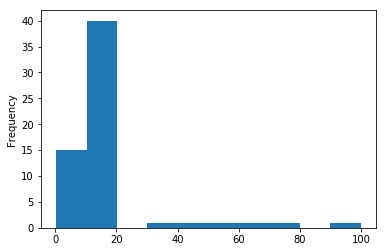

In [20]:
# create the plot to show this data so we can visualize it

# change into percentages of missing data
missing_col_vals_percentage = missing_col_vals / float(len(azdias)) * 100

missing_col_vals_percentage.plot.hist()

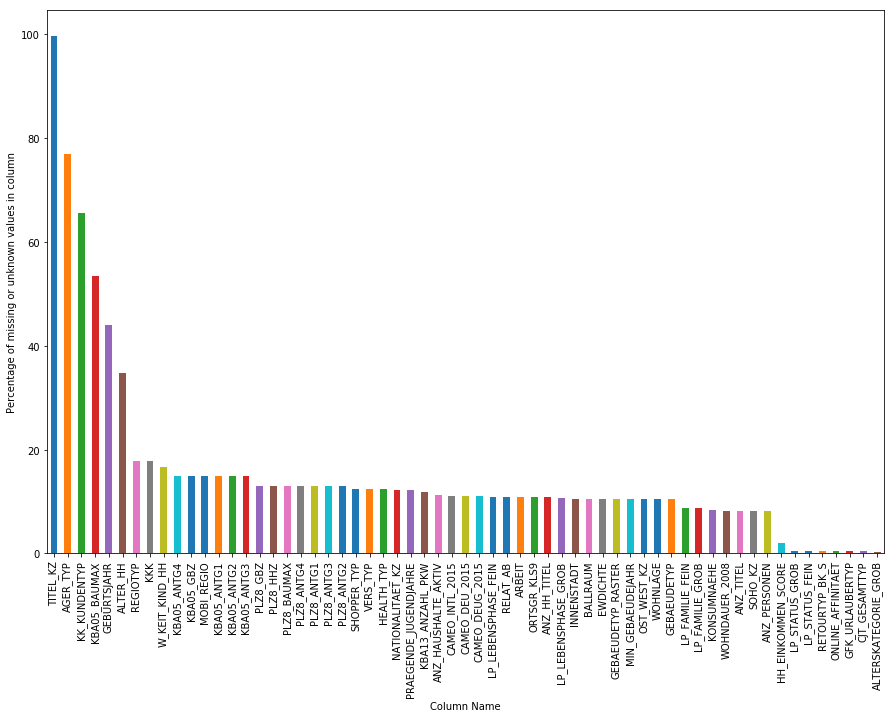

In [21]:
# Investigate patterns in the amount of missing data in each column.
missing_col_vals_percentage.plot.bar(figsize=(15, 10))
plt.xlabel('Column Name')
plt.ylabel('Percentage of missing or unknown values in column')
plt.show()

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# I will have to decide on what an outlier column is based on the percentages. To me this looks like it is around > 20 percent
print(missing_col_vals_percentage.head(8))

# grab columns that are greater than 20 percent missing data
greater_20_percent = missing_col_vals_percentage[missing_col_vals_percentage>20]

# make sure we got the correct columns
greater_20_percent

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
REGIOTYP        17.735668
KKK             17.735668
dtype: float64


TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [23]:
columns_to_drop = greater_20_percent.index.tolist()
columns_to_drop
# we will drop the following columns

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [24]:
# drop columns from the azdias dataset
azdias = azdias.drop(columns_to_drop, axis = 1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

After visualizing all columns, we can see that the majority of columns have less than 20% of their data missing. This means that columns with more than 20% of missing data are considered outliers, and will be dropped from the dataset. This includes:
* 'TITEL_KZ'
* 'AGER_TYP',
* 'KK_KUNDENTYP',
* 'KBA05_BAUMAX',
* 'GEBURTSJAHR',
* 'ALTER_HH'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

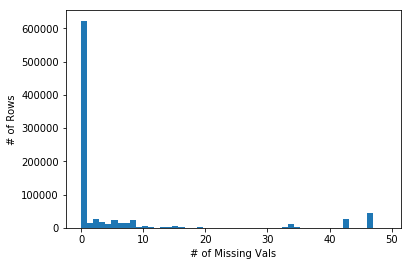

In [25]:
# How much data is missing in each row of the dataset?
missing_row_vals = azdias.isnull().sum(axis=1)
plt.hist(missing_row_vals, bins=50)
plt.xlabel('# of Missing Vals')
plt.ylabel('# of Rows')
plt.show()

In [26]:
# Lets see the percentages to distinguish outliers
missing_row_percentage = missing_row_vals.sort_values() / azdias.shape[1] * 100
missing_row_percentage

445610     0.000000
540274     0.000000
540275     0.000000
540277     0.000000
540280     0.000000
540281     0.000000
540283     0.000000
540284     0.000000
540286     0.000000
540273     0.000000
540287     0.000000
540290     0.000000
540291     0.000000
540292     0.000000
540293     0.000000
540295     0.000000
540296     0.000000
540298     0.000000
540299     0.000000
540289     0.000000
540300     0.000000
540271     0.000000
540269     0.000000
540239     0.000000
540240     0.000000
540241     0.000000
540242     0.000000
540243     0.000000
540244     0.000000
540246     0.000000
            ...    
139521    59.493671
690887    59.493671
690878    59.493671
690876    59.493671
690871    59.493671
139478    59.493671
139236    59.493671
691118    59.493671
691129    59.493671
691317    59.493671
139243    59.493671
139245    59.493671
139248    59.493671
139250    59.493671
139255    59.493671
139267    59.493671
691122    59.493671
691212    59.493671
139323    59.493671


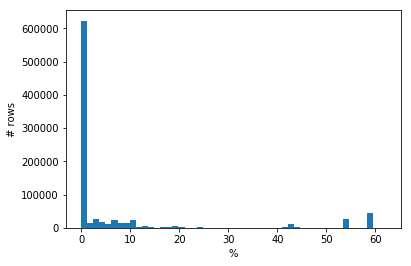

In [27]:
# lets plot this to get a better idea
plt.hist(missing_row_percentage, bins=50)
plt.xlabel('%')
plt.ylabel('# rows')
plt.show()

In [28]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
# i will say that rows that are missing 30% of their values will be in their own subset based on the graph above
rows_less_than_30_percent_missing = azdias[azdias.isnull().sum(axis = 1) < 30].reset_index(drop=True)
rows_greater_than_30_percent_missing = azdias[azdias.isnull().sum(axis = 1) >= 30].reset_index(drop=True)
print(rows_greater_than_30_percent_missing.shape)

(93160, 79)


In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# build the function for creating plots and subpplots NOTE Seaborn is sns
def compare_columns(compare_cols):
    # use seaborns countplot and subplot
    figure, axs = plt.subplots(nrows=len(compare_cols), ncols=2, figsize = (10,20))
    figure.subplots_adjust(hspace = 1, wspace=.5)
    for i in range(len(columns_to_compare)):
        # plot the columns that are missing very few values
        axs[i][0].set_title('Very Few Missing Values')
        sns.countplot(rows_less_than_30_percent_missing[compare_cols[i]], ax=axs[i][0])
        
        # plot the columns that are missing a lot of values
        axs[i][1].set_title('Many Missing Values')
        sns.countplot(rows_greater_than_30_percent_missing[compare_cols[i]], ax=axs[i][1])
    
# Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html


In [30]:
# some columns to use that are missing hardly any values are :
# ALTERSKATEGORIE_GROB, CJT_GESAMTTYP, GFK_URLAUBERTYP, ONLINE_AFFINITIAET, RETOURTYP_BK_S
columns_to_compare = missing_col_vals_percentage[missing_col_vals_percentage <= 5].index.tolist()
columns_to_compare

['HH_EINKOMMEN_SCORE',
 'LP_STATUS_GROB',
 'LP_STATUS_FEIN',
 'RETOURTYP_BK_S',
 'ONLINE_AFFINITAET',
 'GFK_URLAUBERTYP',
 'CJT_GESAMTTYP',
 'ALTERSKATEGORIE_GROB']

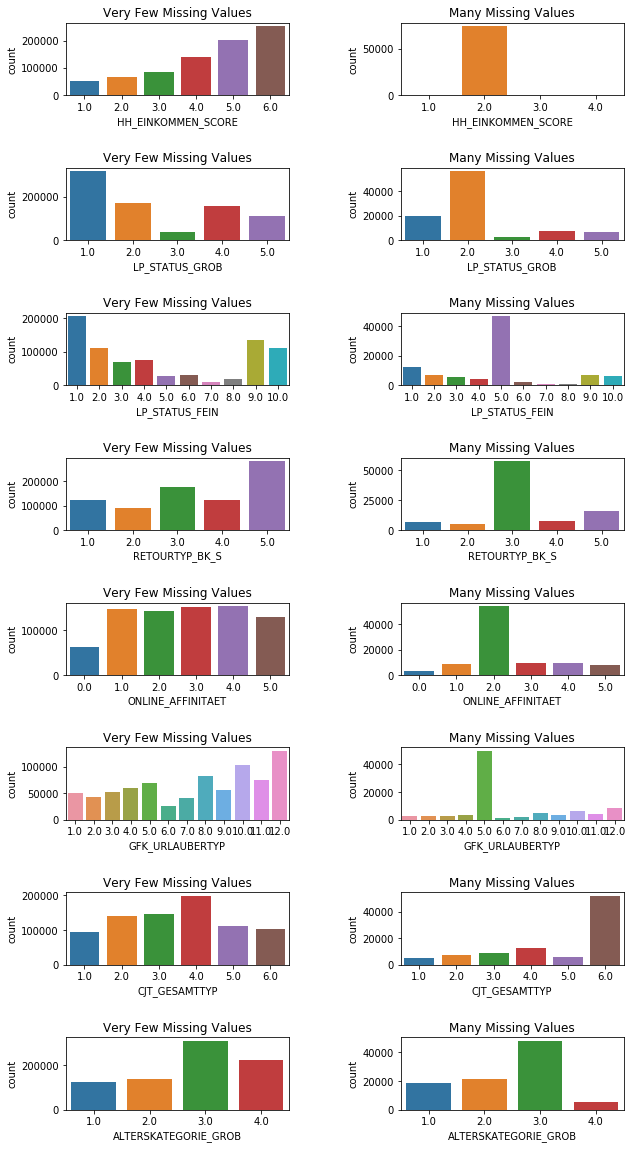

In [31]:
# now we can do our comparison using our new row data that is split
compare_columns(columns_to_compare)

In [32]:
print("Rows before: ", azdias.shape[0])

azdias = azdias[~azdias.index.isin(rows_greater_than_30_percent_missing.index)]
print("Dropped ", rows_greater_than_30_percent_missing.shape[0], "rows.")

print("Rows left: ", azdias.shape[0])

Rows before:  891221
Dropped  93160 rows.
Rows left:  798061


#### Discussion 1.1.3: Assess Missing Data in Each Row

There are around 93160 rows that have 30 percent of its data missing. These were considered outliers and were split into a separate group for comparison. Columns that had less than 5 percent of missing values were selected and compared directly within these rows. Qualitatively, data missing a lot of values is very different when compared to data that is not missing many values. However, there are select features that show similarities within this data. For example, ALTERSKATEGORIE_GROB as seen above. That being said, I still chose to drop these rows from the dataset since they were mostly inconsistent.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?

print(feat_info['type'].value_counts())

print(feat_info.dtypes)

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64
attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_vars = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
categorical_vars

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [35]:
# which of these are a part of the azdias dataset
categorical_vars = [categorical_vars for categorical_vars in categorical_vars if categorical_vars in azdias.columns]
categorical_vars

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [36]:
# split into binary and multi-level vars

binary_columns = []
multi_level_columns = []

for c in categorical_vars:
    if azdias[c].nunique() > 2:
        multi_level_columns.append(c)
    else:
        binary_columns.append(c)
print(binary_columns, "\n")
print(multi_level_columns)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'] 

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [37]:
# im going to drop the multi-level categorical columns

azdias.drop(multi_level_columns, axis = 1, inplace = True)

azdias.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
93160,4.0,2,5,1,4,2,1,4,0,2.0,...,2.0,3.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,2.0
93161,3.0,1,5,1,4,1,1,3,1,3.0,...,2.0,3.0,2.0,1.0,1.0,4.0,3.0,4.0,8.0,3.0
93162,3.0,2,4,3,3,4,2,1,0,3.0,...,3.0,1.0,0.0,0.0,1.0,2.0,3.0,3.0,4.0,2.0
93163,2.0,1,1,5,2,5,4,5,0,3.0,...,1.0,4.0,3.0,1.0,3.0,4.0,3.0,4.0,5.0,3.0
93164,2.0,2,2,5,2,5,3,4,0,1.0,...,3.0,1.0,0.0,0.0,1.0,2.0,3.0,3.0,1.0,2.0
93165,1.0,2,4,3,1,5,4,2,0,3.0,...,2.0,2.0,1.0,1.0,1.0,5.0,5.0,3.0,4.0,2.0
93166,4.0,1,5,1,4,2,1,2,0,1.0,...,3.0,1.0,0.0,0.0,1.0,2.0,3.0,3.0,1.0,2.0
93167,1.0,1,4,5,2,3,4,1,0,2.0,...,4.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,1.0
93168,3.0,2,5,2,4,2,3,1,1,3.0,...,3.0,3.0,2.0,1.0,1.0,4.0,4.0,4.0,8.0,3.0
93169,3.0,2,4,2,4,3,2,2,1,3.0,...,2.0,4.0,2.0,1.0,5.0,5.0,4.0,2.0,4.0,3.0


In [38]:
# lets preview some of this wrangled data
for c in binary_columns:
    print(azdias[c].value_counts())

2    416483
1    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
W    562845
O    152061
Name: OST_WEST_KZ, dtype: int64


In [39]:
# OST WEST KZ has W and O instead of integers... need to fix this!!!!

azdias.loc[:, 'OST_WEST_KZ'].replace({'W' : '0', 'O' : '1'}, inplace = True)

In [40]:
# preview again to make sure it worked
# lets preview some of this wrangled data
for c in binary_columns:
    print(azdias[c].value_counts())

2    416483
1    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
0    562845
1    152061
Name: OST_WEST_KZ, dtype: int64


#### Discussion 1.2.1: Re-Encode Categorical Features

After taking a look at the multi-level categorical features, I decided to drop these from the dataset to keep things more straightforward for further analysis. I re-encoded the OST_WEST_KZ column to 0 and 1 instead of non-numerics.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias['PRAEGENDE_JUGENDJAHRE'].head()


93160     3.0
93161     7.0
93162     8.0
93163    14.0
93164    14.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

## Pulled from data_dictionary.md
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [42]:
# define the interval type variable for decade based on this data
# we have 40s, 50s, 60s, 70s, 80s, 90s so 6 different intervals for decades

def grab_interval(selected_feature):
    if selected_feature in (1,2):
        return 1 # 40s
    elif selected_feature in (3,4):
        return 2 # 50s
    elif selected_feature in (5,6,7):
        return 3 # 60s
    elif selected_feature in (8,9):
        return 4 # 70s
    elif selected_feature in (10,11,12):
        return 5 # 80s
    elif selected_feature in (14,15):
        return 6 # 90s

# define the binary variable for movement (0 or 1)
def grab_movement(selected_feature):
    if selected_feature in (1,3,5,8,10,12,14): # Mainstream
        return 0
    elif selected_feature in (2,4,6,7,9,11,13,15): # Avantgarde
        return 1
    
# create these new columns in the azdias dataset
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(grab_interval)
azdias['MOVEMENTS'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(grab_movement)

# check that these are correct
print(azdias['DECADE'].head())
print(azdias['MOVEMENTS'].head())

# Drop the original feature since we don't need it anymore

azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

93160    2.0
93161    3.0
93162    4.0
93163    6.0
93164    6.0
Name: DECADE, dtype: float64
93160    0.0
93161    1.0
93162    0.0
93163    0.0
93164    0.0
Name: MOVEMENTS, dtype: float64


In [43]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENTS
93160,4.0,2,5,1,4,2,1,4,0,2.0,...,1.0,1.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,0.0
93161,3.0,1,5,1,4,1,1,3,1,3.0,...,2.0,1.0,1.0,4.0,3.0,4.0,8.0,3.0,3.0,1.0
93162,3.0,2,4,3,3,4,2,1,0,3.0,...,0.0,0.0,1.0,2.0,3.0,3.0,4.0,2.0,4.0,0.0
93163,2.0,1,1,5,2,5,4,5,0,3.0,...,3.0,1.0,3.0,4.0,3.0,4.0,5.0,3.0,6.0,0.0
93164,2.0,2,2,5,2,5,3,4,0,1.0,...,0.0,0.0,1.0,2.0,3.0,3.0,1.0,2.0,6.0,0.0


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.



### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [45]:
# going to split this data  by 10s digit, 1s being wealthy, 2s being prosper, 3s being comfort, 4s being less affluent, 5s being poorer

def grab_wealth(feat):
    # use floor division to grab 10s digit only
    if feat // 10 == 1:
        return 1
    elif feat // 10 == 2:
        return 2
    elif feat // 10 == 3:
        return 3
    elif feat // 10 == 4:
        return 4
    elif feat // 10 == 5:
        return 5

def grab_life(feat):
    # use 1s digit
    # 1: pre-fam, 2: young couple, 3: family w school, 4: older fams, 5: elders
    if feat % 10 == 1:
        return 1
    if feat % 10 == 2:
        return 2
    if feat % 10 == 3:
        return 3
    if feat % 10 == 4:
        return 4
    if feat % 10 == 5:
        return 5

# first make this numeric not objects, was objects so was getting str conversion errors
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])

# now apply these functions to create our new columns
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(grab_wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(grab_life)

# drop the old data since we no longer need it
azdias.drop('CAMEO_INTL_2015', axis = 1, inplace=True)

azdias.head()

# Reference
# https://www.w3schools.com/python/python_operators.asp

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENTS,WEALTH,LIFE_STAGE
93160,4.0,2,5,1,4,2,1,4,0,2.0,...,1.0,2.0,3.0,3.0,3.0,2.0,2.0,0.0,4.0,3.0
93161,3.0,1,5,1,4,1,1,3,1,3.0,...,1.0,4.0,3.0,4.0,8.0,3.0,3.0,1.0,1.0,5.0
93162,3.0,2,4,3,3,4,2,1,0,3.0,...,1.0,2.0,3.0,3.0,4.0,2.0,4.0,0.0,4.0,5.0
93163,2.0,1,1,5,2,5,4,5,0,3.0,...,3.0,4.0,3.0,4.0,5.0,3.0,6.0,0.0,5.0,4.0
93164,2.0,2,2,5,2,5,3,4,0,1.0,...,1.0,2.0,3.0,3.0,1.0,2.0,6.0,0.0,4.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

In terms of the PRAEGENDE_JUGENDJAHRE feature set, I found it best to categorize the decades and movements as two different new columns. This was done by creating intervals ranging from the 40s to 90s and converting these to integers 1 through 6 for the decades. As for the movements the columns were converted into binary data whether it represented Mainstream or Avantgarde (now 0 or 1).

Taking a look at CAMEO_INTL_2015 feature set, I found it best to categorize the data based on the 1s and 10s digits that represented wealth placements and life stages respectively. 

I dropped both the original PRAEGENDE_JUGENDJAHRE and original CAMEO_INTL_2015 after engineering these new features.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENTS,WEALTH,LIFE_STAGE
93160,4.0,2,5,1,4,2,1,4,0,2.0,...,1.0,2.0,3.0,3.0,3.0,2.0,2.0,0.0,4.0,3.0
93161,3.0,1,5,1,4,1,1,3,1,3.0,...,1.0,4.0,3.0,4.0,8.0,3.0,3.0,1.0,1.0,5.0
93162,3.0,2,4,3,3,4,2,1,0,3.0,...,1.0,2.0,3.0,3.0,4.0,2.0,4.0,0.0,4.0,5.0
93163,2.0,1,1,5,2,5,4,5,0,3.0,...,3.0,4.0,3.0,4.0,5.0,3.0,6.0,0.0,5.0,4.0
93164,2.0,2,2,5,2,5,3,4,0,1.0,...,1.0,2.0,3.0,3.0,1.0,2.0,6.0,0.0,4.0,3.0


In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# this will show us anything that is an object (non-numeric)
azdias.loc[:, azdias.dtypes == 'O']


,OST_WEST_KZ
93160,1
93161,1
93162,1
93163,1
93164,1
93165,1
93166,1
93167,0
93168,0
93169,0


In [48]:
# convert to numeric and check again
azdias['OST_WEST_KZ'] = pd.to_numeric(azdias['OST_WEST_KZ'])
azdias.loc[:, azdias.dtypes == 'O'] # success if no columns

""
93160
93161
93162
93163
93164
93165
93166
93167
93168
93169


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [60]:
def clean_data(df_to_clean):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = df_to_clean.copy()
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # We will use pandas apply method to apply this function to the dataset
    
    # lets go through feat_info and start replacing to np.NaN
    for idx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[idx]['missing_or_unknown']
        df = df.replace({feat_info.iloc[idx]['attribute']: missing_or_unknown}, np.nan)

    #TITEL_KZ                 889061
    #AGER_TYP                 685843
    #KK_KUNDENTYP             584612
    #KBA05_BAUMAX             476524
    #GEBURTSJAHR              392318
    #ALTER_HH                 310267
        
        
        
    # remove selected columns and rows, ...
    df = df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis = 1)
    
    # ROWS -------------------------------------------
    missing_row_vals = df.isnull().sum(axis=1)
    missing_row_percentage = missing_row_vals.sort_values() / df.shape[1] * 100
    # Write code to divide the data into two subsets based on the number of missing values in each row.
    # i will say that rows that are missing 30% of their values will be in their own subset based on the graph above
    rows_less_than_30_percent_missing = df[df.isnull().sum(axis = 1) < 30].reset_index(drop=True)
    rows_greater_than_30_percent_missing = df[df.isnull().sum(axis = 1) >= 30].reset_index(drop=True)
    print("Rows before clean: ", df.shape[0])
    df = df[~df.index.isin(rows_greater_than_30_percent_missing.index)]
    print("Rows after clean: ", df.shape[0])
    
    # select, re-encode, and engineer column values.
    categorical_vars = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
    categorical_vars = [categorical_vars for categorical_vars in categorical_vars if categorical_vars in df.columns]
    
    binary_columns = []
    multi_level_columns = []
    for c in categorical_vars:
        if df[c].nunique() > 2:
            multi_level_columns.append(c)
        else:
            binary_columns.append(c)
    # drop multi level columns       
    df.drop(multi_level_columns, axis = 1, inplace = True)
    
    # fix OST WEST
    df.loc[:, 'OST_WEST_KZ'].replace({'W' : '0', 'O' : '1'}, inplace = True)
    
    
    # ENGINEER MIXED TYPES -----------------------------
    # create these new columns in the df dataset
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(grab_interval)
    df['MOVEMENTS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(grab_movement)
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])

    # now apply these functions to create our new columns
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(grab_wealth)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(grab_life)
    
    # drop the old data since we no longer need it
    df.drop('CAMEO_INTL_2015', axis = 1, inplace=True)
    
    df['OST_WEST_KZ'] = pd.to_numeric(df['OST_WEST_KZ'])
    
    col_list = df.columns
    
    # we will use an imputer to remove NaN values
    fill_nans = Imputer(strategy="mean", axis=0)
    df = fill_nans.fit_transform(df)
    
    #col_list = df.columns
    
    df = pd.DataFrame(df, columns=col_list)
    
    print("Preprocessing completed on dataframe.")
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_new = azdias.copy()
cols = azdias_new.columns

# we will use an imputer to remove NaN values
fill_nans = Imputer(strategy="mean", axis=0)
azdias_new = fill_nans.fit_transform(azdias_new)

# turn this copy into a dataframe and recheck for missings
azdias_new = pd.DataFrame(azdias_new, columns = cols)
azdias_new.isnull().sum()


ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA05_ANTG4              0
K

In [51]:
# Apply feature scaling to the general population demographics data.

scalar = StandardScaler()
azdias_scaled = scalar.fit_transform(azdias_new)
azdias_scaled = pd.DataFrame(azdias_scaled, columns=cols)
azdias_scaled.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.231412,0.957179,1.454051,-1.241620,0.453026,-0.675111,-1.259957,0.684390,-0.495175,-0.268112,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.052862,-0.832891,-1.701412,-0.573007,0.536028,0.089457
1,0.240123,-1.044737,1.454051,-1.241620,0.453026,-1.329063,-1.259957,-0.053970,2.019490,1.146826,...,-0.692964,0.427850,-0.367319,0.882833,1.245454,-0.054110,-0.970357,1.985153,-1.636902,1.518387
2,0.240123,0.957179,0.697641,0.123572,-0.302845,0.632794,-0.587234,-1.530689,-0.495175,1.146826,...,-0.692964,-1.774003,-0.367319,-0.176995,-0.593198,-0.832891,-0.239302,-0.573007,0.536028,1.518387
3,-0.751165,-1.044737,-1.571589,1.488764,-1.058716,1.286746,0.758211,1.422749,-0.495175,1.146826,...,0.777350,0.427850,-0.367319,0.882833,-0.133535,-0.054110,1.222808,-0.573007,1.260338,0.803922
4,-0.751165,0.957179,-0.815179,1.488764,-1.058716,1.286746,0.085488,0.684390,-0.495175,-1.683050,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.972188,-0.832891,1.222808,-0.573007,0.536028,0.089457
5,-1.742453,0.957179,0.697641,0.123572,-1.814587,1.286746,0.758211,-0.792330,-0.495175,1.146826,...,-0.692964,1.528776,1.562183,-0.176995,-0.593198,-0.832891,1.222808,-0.573007,-1.636902,0.803922
6,1.231412,-1.044737,1.454051,-1.241620,0.453026,-0.675111,-1.259957,-0.792330,-0.495175,-1.683050,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.972188,-0.832891,-1.701412,-0.573007,-1.636902,0.089457
7,-1.742453,-1.044737,0.697641,1.488764,-1.058716,-0.021158,0.758211,-1.530689,-0.495175,-0.268112,...,-0.692964,-0.673077,-0.367319,-1.236822,-1.972188,-1.611672,1.222808,-0.573007,-0.912592,0.803922
8,0.240123,0.957179,1.454051,-0.559024,0.453026,-0.675111,0.085488,-1.530689,2.019490,1.146826,...,-0.692964,0.427850,0.597432,0.882833,1.245454,-0.054110,0.491753,1.985153,-0.912592,0.803922
9,0.240123,0.957179,0.697641,-0.559024,0.453026,-0.021158,-0.587234,-0.792330,2.019490,1.146826,...,2.247664,1.528776,0.597432,-1.236822,-0.593198,-0.054110,-0.239302,1.985153,-0.188282,0.803922


### Discussion 2.1: Apply Feature Scaling

I chose to use an imputer with the strategy of replacing NaNs with the mean.
From sklearn: If “mean”, then replace missing values using the mean along the axis.
Reference: https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html

I then used the Standard Scalar to set up this data with a standard deviation of 1 and mean 0.

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
principal_comp_analysis = PCA()
principal_features = principal_comp_analysis.fit_transform(azdias_scaled)

# load into dataframe
pd.DataFrame(principal_features)

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-2.716949,4.016689,-1.230584,-1.274027,1.130122,-1.912996,1.055721,-2.033320,0.157634,-0.285345,...,-0.050682,0.154474,0.023606,-0.606613,0.507690,0.161567,-0.245488,-0.046412,-0.036532,-0.063455
1,-2.344598,2.525596,2.390492,3.395119,0.246454,-2.516422,-0.798486,2.642861,0.400719,0.429385,...,0.109206,0.143359,0.066857,0.378693,0.011838,-0.081663,0.037899,-0.007829,0.103356,-0.045262
2,-4.019121,-0.520903,-2.587009,-0.272441,4.506106,-0.272186,0.517478,0.661595,2.718615,0.728615,...,0.758118,0.187173,0.482276,0.063888,0.516557,-0.862084,-0.509635,-0.014977,-0.179401,0.061376
3,4.701412,-3.227242,2.736176,-1.423277,-1.308765,-0.276937,-0.647463,-3.794358,1.038724,0.138245,...,0.572102,-0.436182,0.029418,-0.020016,0.157188,-0.519593,0.386288,-0.421052,-0.099611,-0.034637
4,-1.565840,-3.828147,-2.995390,-3.909399,1.002387,-2.483677,1.196378,-0.923059,-1.733992,1.597447,...,-0.006739,0.202991,0.216034,0.158127,-0.093672,-0.339436,-0.543731,-0.461055,-0.061206,-0.046458
5,-2.046569,-3.081743,-1.268217,0.141524,-2.199268,0.156945,0.388388,1.548029,1.146600,-0.155528,...,0.032491,-0.077258,-0.137852,-0.349713,0.597124,0.100035,0.438952,0.040213,0.011680,0.031267
6,-5.305249,1.326750,2.809516,-3.662852,1.057848,-3.059510,1.695627,-0.572409,-1.454308,0.501158,...,-0.163792,0.252902,0.170983,0.184797,-0.653037,0.007770,-0.188397,0.168528,0.038194,-0.073298
7,-4.273617,-5.768689,3.480154,-0.825025,2.875882,0.771152,0.328178,1.199283,-1.489811,0.091090,...,-0.157817,0.630143,0.288770,0.574999,0.331989,-0.261525,-0.775480,-0.372412,-0.105229,0.008096
8,-3.282669,0.927197,-1.556384,5.331031,1.181307,1.762582,-0.641905,-0.103040,1.354106,0.101655,...,0.870008,0.318967,-0.201902,-0.387639,-0.223531,0.298661,-0.436225,0.056487,-0.077375,-0.063126
9,-1.463092,1.921065,-1.580286,3.379050,0.155370,2.552555,-0.288798,-1.302310,1.131515,-0.937913,...,-0.038531,-0.089186,-0.379912,-0.221563,-0.158539,0.415330,-0.528388,0.281899,-0.155840,-0.004855


Text(0,0.5,'Ratio of Variance')

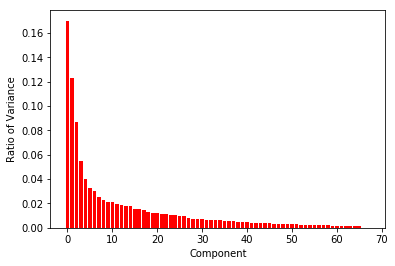

In [53]:
# Investigate the variance accounted for by each principal component.
principal_comp_analysis.explained_variance_ratio_

plt.bar(range(len(principal_comp_analysis.explained_variance_ratio_)), principal_comp_analysis.explained_variance_ratio_, color='red')

plt.xlabel("Component")
plt.ylabel("Ratio of Variance")

Text(0,0.5,'Ratio of Variance')

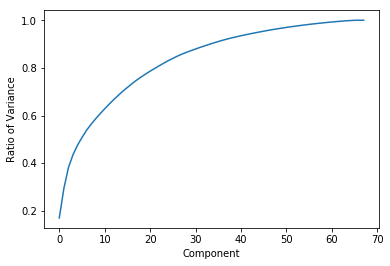

In [54]:
plt.plot(range(len(principal_comp_analysis.explained_variance_ratio_)),np.cumsum(principal_comp_analysis.explained_variance_ratio_), '-')
plt.xlabel("Component")
plt.ylabel("Ratio of Variance")




# reference
# https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.
principal_comp_analysis = PCA(30)
principal_features_new = principal_comp_analysis.fit_transform(azdias_scaled)
pd.DataFrame(principal_features_new)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.716948,4.016689,-1.230588,-1.274022,1.130105,-1.913279,1.055789,-2.033734,0.157073,-0.287730,...,0.457841,1.718013,0.842903,0.674078,-0.442812,-1.824780,-0.091519,0.272232,-1.512275,0.154080
1,-2.344598,2.525596,2.390491,3.395121,0.246407,-2.516440,-0.798344,2.642678,0.400196,0.428368,...,-0.605035,1.135016,0.622553,-0.498807,0.043794,0.247926,0.681250,0.384261,-0.308662,-0.353935
2,-4.019121,-0.520904,-2.587005,-0.272427,4.506142,-0.272239,0.517438,0.661606,2.719129,0.727938,...,-0.393835,-1.118526,-0.931766,0.138362,-1.339158,0.554008,1.187301,-0.969663,-0.327095,-0.547517
3,4.701412,-3.227242,2.736175,-1.423291,-1.308765,-0.276982,-0.647492,-3.794460,1.039185,0.138427,...,-1.036270,-0.362626,-0.853462,-1.022473,-1.829305,0.362819,-0.097680,1.463790,-0.351209,0.497790
4,-1.565840,-3.828148,-2.995388,-3.909375,1.002339,-2.483694,1.196634,-0.923350,-1.734393,1.595965,...,-0.460971,-0.467641,-0.174067,0.071307,-0.584423,0.820351,-1.245640,-0.843724,0.251192,-0.285410
5,-2.046569,-3.081744,-1.268216,0.141552,-2.199404,0.156701,0.389067,1.547323,1.145738,-0.158298,...,-0.501191,-0.102709,0.749885,1.055556,-1.469540,0.581907,-0.454975,0.542995,-0.127930,-0.628288
6,-5.305249,1.326750,2.809515,-3.662848,1.057805,-3.059918,1.695906,-0.573188,-1.454162,0.498272,...,0.239081,0.507130,0.232849,1.069825,0.849408,-0.262945,0.185594,-0.256235,0.315438,0.062585
7,-4.273617,-5.768689,3.480153,-0.825046,2.875799,0.771143,0.328266,1.199042,-1.489898,0.091070,...,0.040239,0.355364,-0.064880,-0.242589,1.224663,-0.217955,0.196003,0.158642,-0.321068,0.809388
8,-3.282669,0.927197,-1.556385,5.331025,1.181417,1.762645,-0.642222,-0.102859,1.354679,0.103571,...,-0.541838,-0.007909,0.240031,-0.831505,0.645740,-0.126637,-0.327351,-0.041022,0.731750,1.140333
9,-1.463092,1.921065,-1.580289,3.379042,0.155371,2.552786,-0.289132,-1.301847,1.130835,-0.937059,...,-1.253280,-0.882343,0.093014,-1.705899,0.325395,1.244936,0.787196,0.012503,0.573151,-0.654981


### Discussion 2.2: Perform Dimensionality Reduction

Based on the explained variance ratio and the cumulative sum of the variance ratio, we can see that at around 30 components over 80% of the variance in the dataset is explained using just these components. I re-ran PCA with 30 components to avoid over generalizing with a lower number of components.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(principal_comp_analysis, component_number):
    # create a dataframe to use later
    df = pd.DataFrame(principal_comp_analysis.components_, columns=list(azdias_scaled.columns))
    weights_list = df.iloc[component_number].sort_values(ascending=False)
    return weights_list

# run the function to test
pca_weights_list = pca_weights(principal_comp_analysis, 0)
print("First principle component: \n", pca_weights_list)

First principle component: 
 PLZ8_ANTG3               0.228488
PLZ8_ANTG4               0.222718
PLZ8_BAUMAX              0.218037
WEALTH                   0.202999
ORTSGR_KLS9              0.201210
EWDICHTE                 0.198963
HH_EINKOMMEN_SCORE       0.174763
FINANZ_HAUSBAUER         0.163466
PLZ8_ANTG2               0.154556
KBA05_ANTG4              0.153053
ARBEIT                   0.144165
RELAT_AB                 0.135817
ANZ_HAUSHALTE_AKTIV      0.135803
KBA05_ANTG3              0.132164
FINANZ_SPARER            0.108867
SEMIO_PFLICHT            0.081810
SEMIO_REL                0.074659
REGIOTYP                 0.067773
SEMIO_RAT                0.066799
DECADE                   0.066221
W_KEIT_KIND_HH           0.058379
SEMIO_MAT                0.056571
SEMIO_FAM                0.055861
SEMIO_TRADV              0.055700
OST_WEST_KZ              0.055092
SEMIO_KAEM               0.046662
SEMIO_KULT               0.043559
FINANZ_UNAUFFAELLIGER    0.043305
PLZ8_HHZ           

In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights_list_2nd = pca_weights(principal_comp_analysis, 1)
print("Second principle component: \n", pca_weights_list_2nd)


Second principle component: 
 ALTERSKATEGORIE_GROB     0.278996
FINANZ_VORSORGER         0.258732
SEMIO_ERL                0.228283
SEMIO_LUST               0.190213
RETOURTYP_BK_S           0.172364
W_KEIT_KIND_HH           0.122996
FINANZ_MINIMALIST        0.111470
FINANZ_HAUSBAUER         0.090156
WOHNDAUER_2008           0.070315
EWDICHTE                 0.065904
ORTSGR_KLS9              0.064803
PLZ8_ANTG3               0.061768
SEMIO_KRIT               0.059701
PLZ8_ANTG4               0.058919
SEMIO_KAEM               0.055348
PLZ8_BAUMAX              0.054575
ANREDE_KZ                0.051832
ARBEIT                   0.048449
RELAT_AB                 0.046524
KBA05_ANTG4              0.046127
HH_EINKOMMEN_SCORE       0.044960
WEALTH                   0.044142
ANZ_HAUSHALTE_AKTIV      0.043228
PLZ8_ANTG2               0.042530
VERS_TYP                 0.030971
ANZ_HH_TITEL             0.026549
SEMIO_DOM                0.025418
KBA05_ANTG3              0.022322
LIFE_STAGE        

In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights_list_3rd = pca_weights(principal_comp_analysis, 2)
print("Third principle component: \n", pca_weights_list_3rd)


Third principle component: 
 SEMIO_VERT               0.354059
SEMIO_SOZ                0.290426
SEMIO_KULT               0.282358
SEMIO_FAM                0.238234
FINANZ_MINIMALIST        0.138325
RETOURTYP_BK_S           0.078471
SEMIO_MAT                0.068793
FINANZ_VORSORGER         0.063780
W_KEIT_KIND_HH           0.063227
GREEN_AVANTGARDE         0.062313
SEMIO_REL                0.060565
MOVEMENTS                0.045726
ALTERSKATEGORIE_GROB     0.040002
PLZ8_BAUMAX              0.035460
PLZ8_ANTG4               0.032276
ORTSGR_KLS9              0.031839
PLZ8_ANTG3               0.030744
EWDICHTE                 0.030071
ARBEIT                   0.024352
RELAT_AB                 0.021150
WOHNDAUER_2008           0.020386
PLZ8_ANTG2               0.019585
HH_EINKOMMEN_SCORE       0.019211
SEMIO_LUST               0.017333
WEALTH                   0.016771
KBA05_ANTG4              0.015857
ANZ_HAUSHALTE_AKTIV      0.015145
OST_WEST_KZ              0.012742
ANZ_TITEL          

### Discussion 2.3: Interpret Principal Components

Based on my results, principal component 1 has the strongest feature weights as follows:
- PLZ8_ANTG3               0.228488
- PLZ8_ANTG4               0.222718
- PLZ8_BAUMAX              0.218037

The most negative weights for principal component 1 are: 
- KBA05_ANTG1             -0.221724
- PLZ8_ANTG1              -0.227791
- MOBI_REGIO              -0.239059

We can see from this result that these six features listed above are contributing most to the variance in our data when looking ata the first principal component. PLZ8_G3 and PLZ8_G4 have a strong positive correlation to eachother which makes sense since they are looking at families with around 10 homes in the region.

Based on principal component 2 we can see that the strongest features are as follows:
- ALTERSKATEGORIE_GROB     0.278996
- FINANZ_VORSORGER         0.258732
- SEMIO_ERL                0.228283

The most negatively weighted features for p.c. 2 are:
- SEMIO_REL               -0.259805
- FINANZ_SPARER           -0.268777
- DECADE                  -0.270897

We can see here that ALTERSKATEGORIE_GROB and DECADE are contributing the most to the variance with component 2, and is positively correlated with FINANZ_VORSORGER, which makes sense due to ALTERSKATEGORIE_GROB representing estimated age and FINANZ_VORSORGER representing the financial mindset of being prepared. This aligns closely to the people around me today.


Based on principal component 3 we can see that the strongest features are as follows:
- SEMIO_VERT               0.354059
- SEMIO_SOZ                0.290426
- SEMIO_KULT               0.282358

The most negatively weighted features for p.c. 3 are:
- SEMIO_DOM               -0.332732
- SEMIO_KAEM              -0.360524
- ANREDE_KZ               -0.362832

This third principal component is interesting since it is showing that SEMIO or Personality typology, is causing major varations in our data whilst looking at the strongest positive and negative weights. This might mean that this feature has both a positive and negative correllation when certain personality traits line up. We can see here that SEMIO_DOM and SEMIO_KEM, dominant traits and combative traits are closely related.






(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
# Over a number of different cluster counts...
# create arrays to store scores for later
scores = []

for i in range(2,30):
    print(i," iteration")
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(principal_features_new)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(principal_features_new))
    scores.append(score)

scores

2  iteration
3  iteration
4  iteration
5  iteration
6  iteration
7  iteration
8  iteration
9  iteration
10  iteration
11  iteration
12  iteration
13  iteration
14  iteration
15  iteration
16  iteration
17  iteration
18  iteration
19  iteration
20  iteration
21  iteration
22  iteration
23  iteration
24  iteration
25  iteration
26  iteration
27  iteration
28  iteration
29  iteration


[40851944.765850462,
 37304895.487400025,
 35233295.967607394,
 33632592.340433113,
 32394267.630128112,
 31355553.313714921,
 30580777.175802842,
 29823214.232381616,
 29127800.437807959,
 28596024.990961604,
 28086043.248807427,
 27351012.251063615,
 26976709.027315866,
 26572851.233196244,
 26378539.942938961,
 26001050.124971628,
 25754160.103143733,
 25242182.880144272,
 25009752.652504735,
 24751557.283440039,
 24483353.178349953,
 24315471.518503338,
 23900945.611757398,
 23767844.028496161,
 23577215.224209566,
 23359990.799133558,
 23149725.09119948,
 22967688.649731081]

Text(0,0.5,'Score')

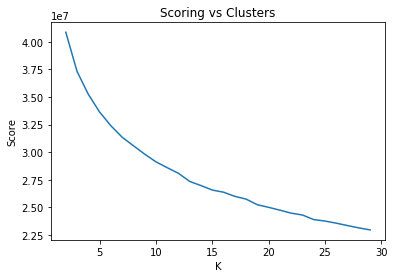

In [6]:
# Creating a backup of scores to avoid running above again
counts = list(range(2,30))
counts
scores_save = [40851944.765850462,
 37304895.487400025,
 35233295.967607394,
 33632592.340433113,
 32394267.630128112,
 31355553.313714921,
 30580777.175802842,
 29823214.232381616,
 29127800.437807959,
 28596024.990961604,
 28086043.248807427,
 27351012.251063615,
 26976709.027315866,
 26572851.233196244,
 26378539.942938961,
 26001050.124971628,
 25754160.103143733,
 25242182.880144272,
 25009752.652504735,
 24751557.283440039,
 24483353.178349953,
 24315471.518503338,
 23900945.611757398,
 23767844.028496161,
 23577215.224209566,
 23359990.799133558,
 23149725.09119948,
 22967688.649731081]

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(counts, scores_save)
plt.title('Scoring vs Clusters')
plt.xlabel('K')
plt.ylabel('Score')

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=18)
model_gen_pop = kmeans.fit(principal_features_new)
predictions_general = model_gen_pop.predict(principal_features_new)

predictions_general

array([ 2, 16, 13, ...,  5,  1,  4], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

The elbow in the above chart appears to occur at around 18 clusters. This is the point at which there are diminishing returns for adding more complexity to the clustering algorithm. 


(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [3]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [61]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_processed = clean_data(customers) # this will run our clean function that we defined earlier in the project

customers_processed.head()

Rows before clean:  191652
Rows after clean:  141725
Preprocessing completed on dataframe.


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.0,2.0,2.0,5.0,3.0,5.0,5.0,3.0,0.0,1.953821,...,1.000000,4.000000,4.000000,4.000000,7.000000,5.000000,2.875585,0.492673,1.00000,3.00000
1,3.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,1.953821,...,1.554663,3.636646,3.624227,2.823007,5.117355,2.896732,2.875585,0.492673,2.59701,3.36958
2,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,0.0,2.000000,...,1.000000,4.000000,5.000000,4.000000,3.000000,5.000000,1.000000,0.000000,1.00000,5.00000
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.000000,...,1.000000,4.000000,4.000000,3.000000,6.000000,2.000000,2.000000,1.000000,1.00000,5.00000
4,4.0,2.0,2.0,1.0,5.0,1.0,1.0,5.0,0.0,1.000000,...,4.000000,3.000000,2.000000,3.000000,7.000000,5.000000,3.000000,0.000000,3.00000,1.00000


In [64]:
# Apply the data scalar to customers data, note that I applied the imputer during the cleaning function
customers_scaled = scalar.transform(customers_processed)
customers_scaled = pd.DataFrame(customers_scaled, columns=list(customers_processed))

# Apply the principal component analysis we created on the general population
customers_pca = principal_comp_analysis.transform(customers_scaled)

# Do KMeans using our chosen number of clusters SHOULD BE 18 Clusters
customers_clustered = model_gen_pop.predict(customers_pca)

customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENTS,WEALTH,LIFE_STAGE
0,-1.742453,0.957179,-0.815179,1.488764,-0.302845,1.286746,1.430933,-0.053970,-0.495175,-0.333452,...,-0.692964,0.427850,0.597432,0.882833,0.785791,1.503453,-1.061311,0.687328,-1.636902,0.089457
1,0.240123,0.957179,-0.058769,0.806168,-0.302845,1.286746,1.430933,-0.053970,-0.495175,-0.333452,...,-0.285199,0.027824,0.234904,-0.364577,-0.079591,-0.134533,-1.061311,0.687328,-0.480172,0.353509
2,1.231412,-1.044737,1.454051,-1.241620,1.208897,-1.329063,-0.587234,-0.792330,-0.495175,-0.268112,...,-0.692964,0.427850,1.562183,0.882833,-1.052862,1.503453,-2.432467,-0.573007,-1.636902,1.518387
3,1.231412,-1.044737,1.454051,-1.241620,1.208897,-1.329063,-0.587234,-0.792330,2.019490,-1.683050,...,-0.692964,0.427850,0.597432,-0.176995,0.326128,-0.832891,-1.701412,1.985153,-1.636902,1.518387
4,1.231412,0.957179,-0.815179,-1.241620,1.208897,-1.329063,-1.259957,1.422749,-0.495175,-1.683050,...,1.512507,-0.673077,-1.332071,-0.176995,0.785791,1.503453,-0.970357,-0.573007,-0.188282,-1.339473


In [ ]:
# extra

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,0,'Number of Clusters')

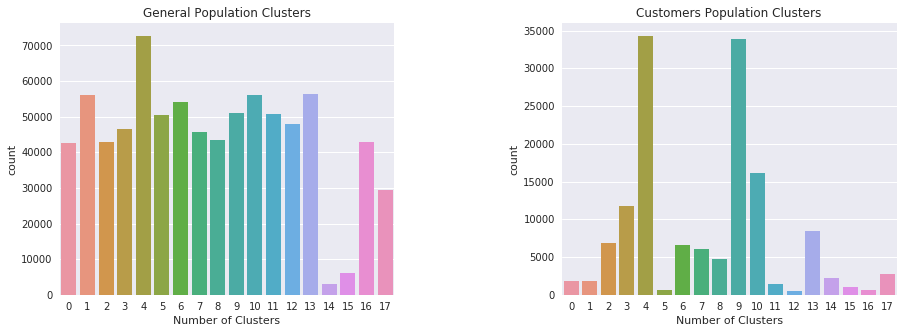

In [116]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
figure.subplots_adjust(hspace = 1, wspace=.5)

sns.set(style="darkgrid")

sns.countplot(predictions_general, ax=axs[0])
axs[0].set_title('General Population Clusters')
axs[0].set_xlabel('Number of Clusters')


sns.countplot(customers_clustered, ax=axs[1])
axs[1].set_title('Customers Population Clusters')
axs[1].set_xlabel('Number of Clusters')


In [89]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# for this i will be targeting clusters 4. These are overrepresented in the customer data
# transform the data back into its original principal components
cluster_4 = scalar.inverse_transform(principal_comp_analysis.inverse_transform(model_gen_pop.cluster_centers_[4]))
cluster_4_pandas = pd.Series(data = cluster_4, index = customers_scaled.columns)

cluster_4_pandas

ALTERSKATEGORIE_GROB       3.308848
ANREDE_KZ                  1.044352
FINANZ_MINIMALIST          3.667480
FINANZ_SPARER              1.959442
FINANZ_VORSORGER           4.175628
FINANZ_ANLEGER             1.865804
FINANZ_UNAUFFAELLIGER      1.955040
FINANZ_HAUSBAUER           3.068959
GREEN_AVANTGARDE           0.036879
HEALTH_TYP                 2.287328
LP_LEBENSPHASE_FEIN       13.021551
LP_LEBENSPHASE_GROB        3.920802
RETOURTYP_BK_S             4.180708
SEMIO_SOZ                  4.954653
SEMIO_FAM                  5.155678
SEMIO_REL                  3.852978
SEMIO_MAT                  4.274706
SEMIO_VERT                 5.834488
SEMIO_LUST                 4.828109
SEMIO_ERL                  4.178236
SEMIO_KULT                 4.944657
SEMIO_RAT                  2.691482
SEMIO_KRIT                 3.757788
SEMIO_DOM                  3.388162
SEMIO_KAEM                 2.826592
SEMIO_PFLICHT              3.403929
SEMIO_TRADV                2.939417
SOHO_KZ                    0

In [90]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# a cluster that is underrepresented is cluster 16: lets take a closer look
cluster_16 = scalar.inverse_transform(principal_comp_analysis.inverse_transform(model_gen_pop.cluster_centers_[16]))

# we will convert to a series to look into this cluster
cluster_16_pandas = pd.Series(data = cluster_16, index = customers_scaled.columns)

cluster_16_pandas

ALTERSKATEGORIE_GROB       3.278908
ANREDE_KZ                  1.052619
FINANZ_MINIMALIST          4.843906
FINANZ_SPARER              1.629388
FINANZ_VORSORGER           4.169011
FINANZ_ANLEGER             1.485563
FINANZ_UNAUFFAELLIGER      2.183757
FINANZ_HAUSBAUER           1.893485
GREEN_AVANTGARDE           0.967690
HEALTH_TYP                 2.049515
LP_LEBENSPHASE_FEIN       24.775995
LP_LEBENSPHASE_GROB        7.214925
RETOURTYP_BK_S             3.934357
SEMIO_SOZ                  5.268731
SEMIO_FAM                  4.884201
SEMIO_REL                  3.759853
SEMIO_MAT                  3.918524
SEMIO_VERT                 6.234181
SEMIO_LUST                 5.272300
SEMIO_ERL                  4.099179
SEMIO_KULT                 4.885742
SEMIO_RAT                  2.698024
SEMIO_KRIT                 3.233775
SEMIO_DOM                  3.414305
SEMIO_KAEM                 2.715163
SEMIO_PFLICHT              3.298526
SEMIO_TRADV                3.163184
SOHO_KZ                    0

### Discussion 3.3: Compare Customer Data to Demographics Data

There is a clear connection between the general population clusters and the customer clusters. In terms of clusters that are very representative of specific subsets of the general population, we have clusters 4, 9, and 10. This means that people from these segments of the population are popular with the mail-order company. 


By comparing the above results to the data dictionary we can gather information about these populations. Taking a closer look at cluster 4 over-representativie results, we can see that people who are in life stage of Families With School Age Children (LIFE_STAGE of 2.814763) are popular with the mail-order company. We can also see that the number of 3-5 family homes in the PLZ8 region shows a correlation to increased customer represenation (PLZ8_ANTG2 3.064570). Going through each category in the data dictionary and matching our numbers above to the traits will give us a very accurate representation as to who is representative of the customer base. 

We can also look at our engineered wealth characteristic. Based on cluster 4, we can see that wealth of customers is generally around less-affluent households (WEALTH 3.737003). 

Taking a look at the under-representative customers as comapred to the general population we can see that people who are investors do not show much interest in this company (FINANZ_ANLEGER 1.485563 - very high to high). Looking at our engineered wealth characteristic, the most under-represented population is people who are in prosperous households (WEALTH ~2.0). 

The company should now be able to focus efforts around increasing their representation based on clusters that show little correspondence to the general population such as cluster 16. They can also increase their customers by targeting more people that are similar to those that are well represented in the highly correlated clusters such as cluster 4 and 9. 


(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.